# TODO : remove all 'TODO's !

# TODO : clearly indicate which cells are demos and which require interaction
- try to use 'tags' to do this; are they visible when opening the notebook for the first time?

# Data analysis - Introduction to Jupyter Notebooks for Nuclear Physics Laboratories

## Table of Content

* [About this Notebook](#about)


* [Importing python packages](#import)


* [Read experimental data from file](#read)
    * [Loading spectrum](#load)
    * [Plotting the data](#plot)


* [Analyzing the data](#fit)
    * [Fitting a Gaussian](#gaussian)
        * [Calculate Peak Area](#peak_area)
        * [Analysis code](#code_gaussian)
        * [Gaussian widget](#widget_gaussian)
    * [Fitting a Gaussian with linear background](#background)
        * [Analysis code](#code_background)
        * [Background widget](#widget_background)
    * [Fit a line - Energy calibration](#line)
    * [Statistical analysis - Error propagation](#stat)

## About this Notebook <a name="about"></a>

The purpose of this _jupyter_ notebook is to introduce data analysis in the
frame of gamma spectroscopy. The example programming language is _Python3_ , but
of course most coding languages can do the job properly. If you have never
programmed before there are so many great tutorials available across the web.
There even exist plenty _Open Online Courses_ , e.g.
https://www.coursera.org/learn/python. Please have a look around for the one
that you like the best. However, note that you do not need to be a
Python programmer to pass the lab: what you find in this notebook is enough to get you going!

The data analysis can roughly be divided into four steps:
1. Read experimental data from file.
2. Identify peak positions.
3. Calibrate the detector response.
4. Perform a statistical analysis (e.g. error propagation) and present results.

A dedicated python library, i.e. a folder with already written code, located in
`HelpCode`, have been implemented for the data analysis connected to your labs. The folder comprises functions that support 1-3 of the
above-mentioned steps.

Full Python3 coding examples of how to perform the different steps of the data
analysis is given below. Every example is finished with a template of how the
`HelpCode`-folder can be used to perform the same calculations.


## Before we start: Jupyter Basics
- running cells
- output printed below cell, code 'side-effects' are kept as Python is running in the background as 'kernel'
- order of cell executions matters!
- when having issues: use 'undo'
- restarting (without losing changes!): restart kernel (and clear output)

**TODO : extend on instructions**

## Python Basics and How Python Relates to Matlab

You might not *need* this, but it could make it easier to read and modify the code:

In [1]:
# this is a comment and will do nothing but help you understand the code.
# comments have a '#' before them.
# this is code to print something into the notebook:
print("Hello world!")
# this defines a variable 'a' that holds the value '5':
a = 5
# printing it gives it's value:
print("The variable 'a' is: {}".format(a))
# doing arithmetics:
print("a^2 = {}".format(a*a))
# TODO: a list
# TODO: the index starting from 0
# TODO: slicing a list
# TODO: change print statements in rest of code to follow same standard
# TODO: separate these lines into individual cells

Hello world!
The variable 'a' is: 5
a^2 = 25


In [2]:
b = 10
print(f"b is : {float(b)}")
print("b is : {}".format(b))

b is : 10.0
b is : 10


## Importing python libraries <a name="import"></a>

Here is **the full list of modules** needed to run the code in the Jupyter Notebook. 

In [3]:
# TODO : remove .py files from the repo that are not explicitly used here!

# Package that supports working with large arrays
import numpy as np  

# Package for plotting; 
# first line makes plots interactive, 
# second actually loads the library
%matplotlib notebook
import matplotlib.pyplot as plt

# Function that fits a curve to data 
from scipy.optimize import curve_fit

# Custom pakages prepared for you to use when analyzing experimental data from labs 
import fithelpers, histhelpers, MCA, fittingFunctions

The very first line inserts the parent directory to the search path such that the analysis code in `fithelpers.py`, `histhelpers.py` and `MCA.py` can be found by `python`. You will likely need most of the above modules during the labs. **TODO: MOVE THE FILES INTO THE SAME FOLDER HIERACHY**

The code below is only needed for the interactive demonstrations within this notebook, so please run it here as well:

In [4]:
# Package to create interactive plots
# Only needed in this demo!
from ipywidgets import interact, interactive, fixed, widgets, Button, Layout
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

--------------------------------------------------------------------------------------------------------------

# Read experimental data from file <a name="read"></a>

## Loading spectrum <a name="load"></a>

With the help of the function `load_spectrum` from package `MCA` one can read the experimental data from one data file as follows:

In [5]:
data = MCA.load_spectrum("FYSC12-Intro/test_data.Spe")

_If you are interested in how to read and write files in Python see e.g. http://www.pythonforbeginners.com/files/reading-and-writing-files-in-python or you could have a look at the source code in [MCA.py](../MCA.py)._

`data` is an object of a class `Spectrum` in which we store information about our histogram: `bin_edges` and `bin_centers` variables give us information about our **channels** and `counts` is used to store  **counts** (cf. [MCA.py](MCA.py)). See for instance: 

In [6]:
print('bin edges = ', data.bin_edges)
print('bin centers = ', data.bin_centers)
print('counts = ', data.counts)

bin edges =  [   0    1    2 ... 8190 8191 8192]
bin centers =  [5.0000e-01 1.5000e+00 2.5000e+00 ... 8.1895e+03 8.1905e+03 8.1915e+03]
counts =  [0. 0. 0. ... 0. 0. 0.]


## Plotting the data <a name="plot"></a>

It is always good to visualise your data. This is how you can plot and visualise it:

<IPython.core.display.Javascript object>


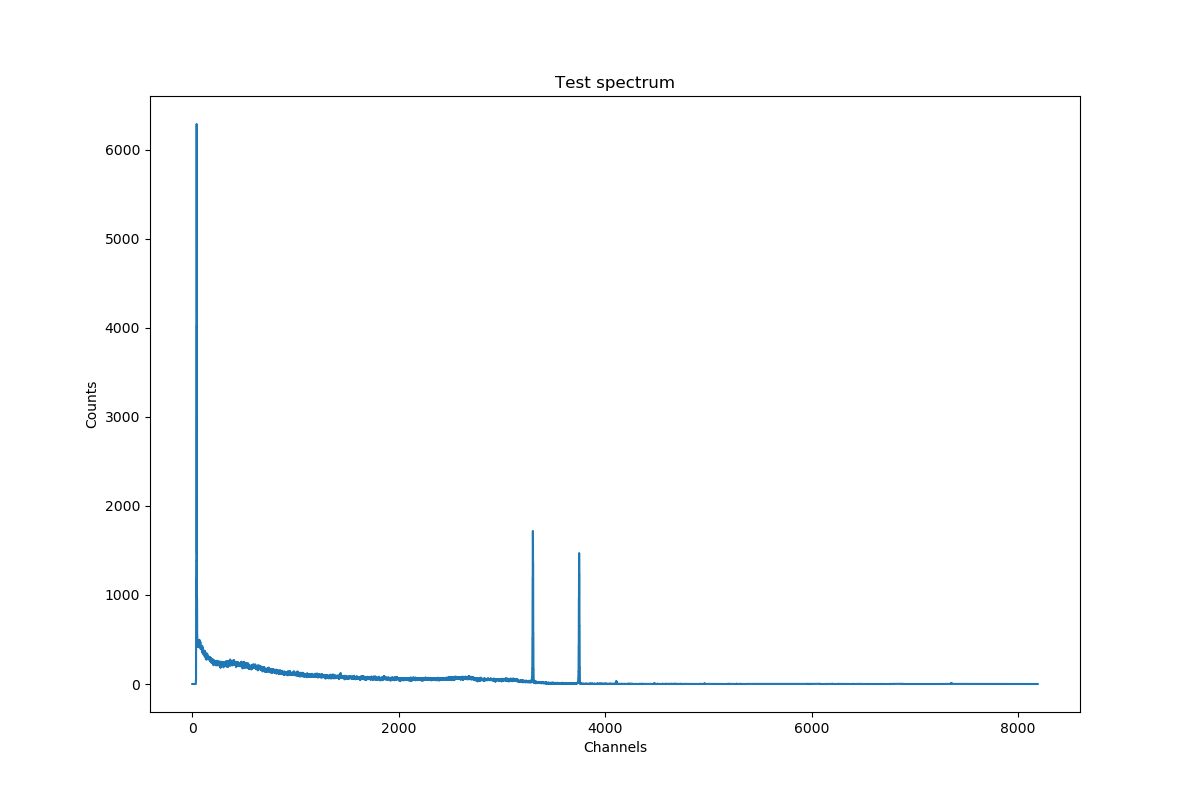

Text(0, 0.5, 'Counts')

In [7]:
plt.figure(figsize=(12, 8))
# with the data read in with the first routine
plt.step(data.bin_centers, data.counts, where='mid', label='step')

plt.title("Test spectrum") # set title of the plot
plt.xlabel("Channels")     # set label for x-axis 
plt.ylabel("Counts")       # set label for y-axis 
#plt.savefig("test_spectrum.png") # This is how you save the figure. Change the extension for different file types such as pdf or png.


## Could be useful to see this in log scale..?
# plt.yscale('log')
# plt.ylim(ymin=1)

--------------------------------------------------------------------------------------------------------------

# Analyzing data <a name="fit"></a>

In $\gamma$-ray (or other radiation) spectroscopy measurements, the goal is usually to determine the energy and the intensity of the radiation. To extract the energy of a given emission line (or use it for calibration puposes), the centroid of a peak must be determined. Area of the peak represents to the intensity of the radiation. A good way to find the peak centroid and area is to fit a Gaussian to the peak. 

## Fitting a Gaussian <a name="gaussian"></a>

When we say that we "fit" a function to data, we mean that we are looking for the set of parameters to the function that give the best possible approximation of the data. The algorithm for this usually works iteratively: it starts with some initial guesses for the parameters and then varies in steps. Each time, the (squared) differences to the data are considered; once these are minimized, the algorithm returns the result to the user, typically with some additional statistical information that hints at the quality of the result.

A fit therefore needs four ingredients:
* the data to fit (often a *subset* of the full data set, i.e. the peak region)
* a function
* initial guesses for its parameters, i.e. a starting point
* an algorithm to perform the fit with

In this notebook, we use the function `curve_fit` from the `scipy.optimize` module for the latter. If you want, you find more detailed information in the [reference documentation to curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). It uses a method called least squares which you can read about in most course literature on statistics and for instance on [Wolfram Alpha](http://mathworld.wolfram.com/LeastSquaresFitting.html).

Specifically, we will fit a Gaussian function. Read up on the Gaussian function and its parameters here: [https://en.wikipedia.org/wiki/Gaussian_function](https://en.wikipedia.org/wiki/Gaussian_function)

The following code shows how to use the function `curve_fit` to fit a peak in
the data that was loaded in the cells above (i.e. _you will need to execute the above code
section once before this section will work_).

**You might get an error**, if you make a mistake in your initial guesses and the fit does not converge. Just double-check the values and try some others!

**If it doesn't work or feels overwhelming to deal with curve_fit directly**, move on, there will be more and simpler exercises on fitting below (with error handling ;).

# TODO : add here a widget which allows to manually adjust Gaussian parameters to fit one of the peaks
- adjust text above to reflect this

In [ ]:
# Creating a Gaussian

In [8]:
def GaussFunc(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

<IPython.core.display.Javascript object>


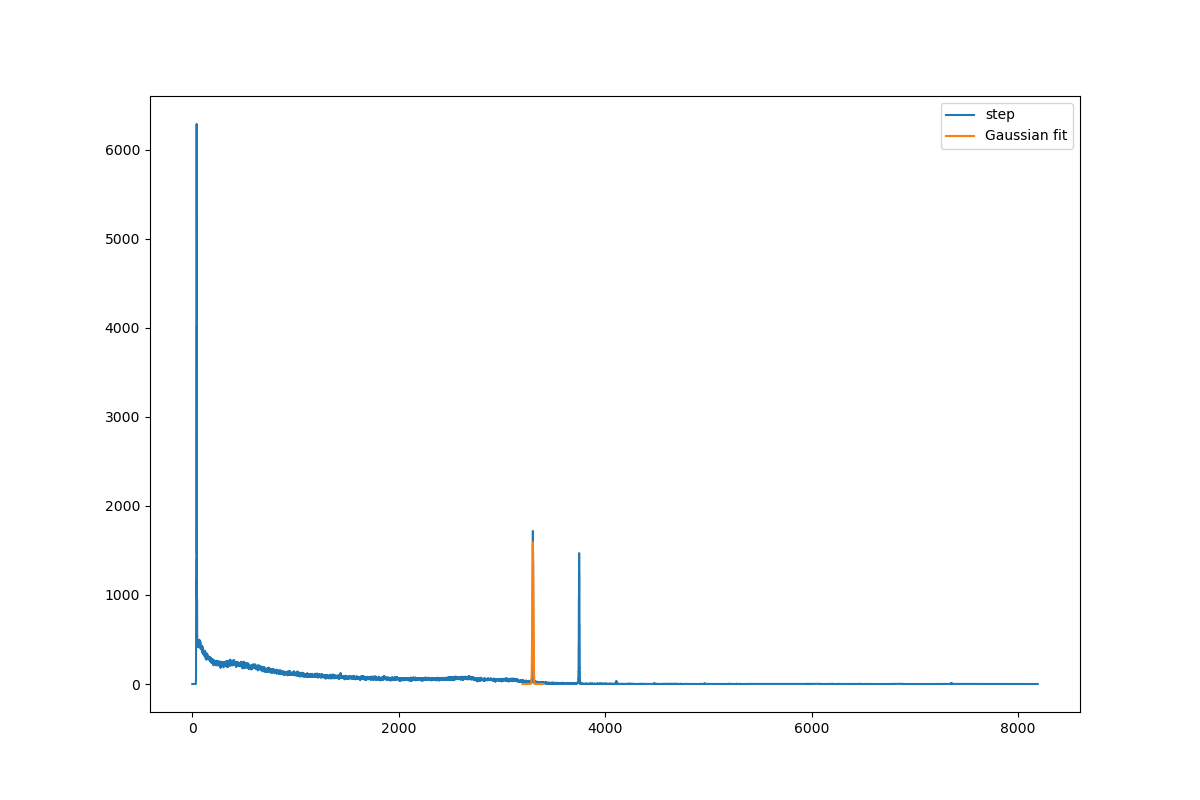

In [11]:
def plot_manual_gaussian(x, region_start, region_stop, A, mu, sigma):
    region = (region_start < x) & (x < region_stop)
    peak_region_bc     = data.bin_centers[region]
    ### Plot your Gaussian fit
    plt.figure(figsize=(12, 8))
    plt.step(data.bin_centers, data.counts, where='mid', label='step')
#     plt.xlim([2750, 4250])
#     plt.ylim([0, 1800])
    plt.plot(peak_region_bc, GaussFunc(peak_region_bc, A, mu, sigma), label = 'Gaussian fit') # plotting the Gaussian
    plt.legend() # adds a legend with all 'label'ed plots!

region_start = 3200
region_stop = 3400
A = 1600
mu = 3300
sigma = 5
plot_manual_gaussian(data.bin_centers, region_start, region_stop, A, mu, sigma)

In [28]:
mu_widget = widgets.IntSlider(value=2000, min=1, max=8000, step=1, description=r'mu_guess')
A_widget = widgets.IntSlider(value=1000, min=0, max=6000, step=1, description=r'A')
sigma_widget = widgets.IntSlider(value=10, min=0, max=100, step=1, description=r'sigma')
region_start_widget = widgets.IntSlider(value=2, min=1, max=7500, step=1, description=r'region_start')
region_stop_widget = widgets.IntSlider(value=2, min=10, max=8000, step=1, description=r'region_stop')


interactive_plot15=interact.options(manual=True, manual_name="Update")

@interactive_plot15(
    mu = mu_widget, A = A_widget, sigma= sigma_widget,  region_start=region_start_widget, region_stop=region_stop_widget)

def interactive_plot_manual_Gauss(mu = mu_widget.value, A = A_widget.value, sigma= sigma_widget.value, region_start=region_start_widget.value, region_stop=region_stop_widget.value):
    plot_manual_gaussian(data.bin_centers, region_start, region_stop, A, mu, sigma)

interactive(children=(IntSlider(value=2000, description='mu_guess', max=8000, min=1), IntSlider(value=1000, de…

# TODO : introduce fitting of data using curve_fit
- let the students adjust the parameters to the ones that they have determined before
- hint at showing 'summary' functions later that will do all this in one go

<IPython.core.display.Javascript object>


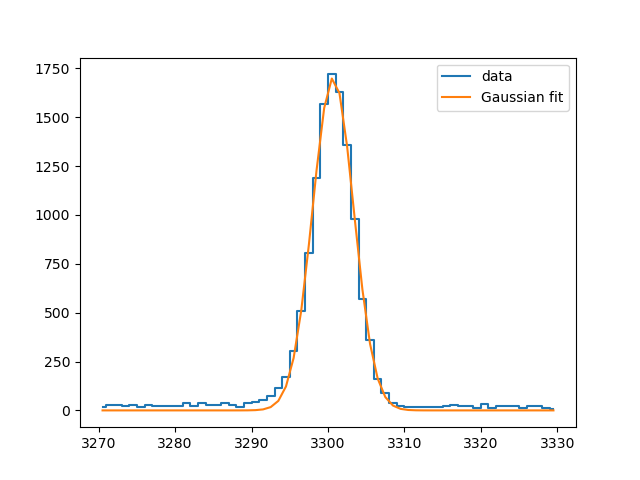

Estimates of (A mu sigma) = ( 1701.4383000257183 3300.673963717905 2.690781591454283 )

Covariance matrix = 
 [[ 2.59876260e+02  5.00888568e-06 -2.73992273e-01]
 [ 5.00888568e-06  8.66625154e-04 -7.92161314e-09]
 [-2.73992273e-01 -7.92161314e-09  8.66625137e-04]] 

Uncertainties in the estimated parameters: 
[ sigma^2(A) sigma^2(mu), sigma^2(sigma) ] = 
[ 259.87625998836404 0.0008666251536173387 0.0008666251372927012 ]


In [12]:
##### Preparing out inputs to the algorithm:

### 1. define the data to fit
# define limits to the data (only want to fit peak!)
region_start = 3270  # bins where to start fitting
region_stop  = 3330  # bins where to stop fitting
# these define a region of interest in our data binning:
region = (region_start < data.bin_centers) & (data.bin_centers < region_stop)
# now limit our data by 'slicing' it, limiting it to the region of interest:
peak_region_bc     = data.bin_centers[region]
peak_region_counts = data.counts[region]


### 2. the function
def GaussFunc(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


### 3. our initial guesses:
mu_guess = 3300                    # a guess for position of peak centroid
A_guess = peak_region_counts.max() # amplitude guess: take max of region!
# TODO : make students guess A as well?

sigma_guess = 1                    # let the fit figure out the rest :)

guess = [A_guess, mu_guess, sigma_guess] # our initial guess of parameters for a Gaussian fit 


### 4. Now we can perform the fit using curve_fit:

estimates, covar_matrix = curve_fit(GaussFunc,           # name of the function
                                    peak_region_bc,      # your xdata
                                    peak_region_counts,  # your ydata
                                    p0=guess)            # initial guess for the parameters

A, mu, sigma = estimates[0], estimates[1], estimates[2] # unpack results

### Plot your Gaussian fit
plt.figure()
plt.step(peak_region_bc, peak_region_counts, where='mid', label='data')                   # plotting the data 
plt.plot(peak_region_bc, GaussFunc(peak_region_bc, A, mu, sigma), label = 'Gaussian fit') # plotting the fit
plt.legend() # adds a legend with all 'label'ed plots!

### Print information about the resulting parameters
print("Estimates of (A mu sigma) = (", A, mu, sigma, ")\n")
print("Covariance matrix = \n", covar_matrix, "\n")
print("Uncertainties in the estimated parameters: \n[ sigma^2(A) sigma^2(mu), sigma^2(sigma) ] = \n[", covar_matrix[0][0], covar_matrix[1][1], covar_matrix[2][2], "]" )


### Calculating Peak Area <a name="peak_area"></a>

There are different ways in how to calculate the area of a peak in a spectrum. The by far easiest method is to calculate the area of the fitted Gaussian function (see [https://en.wikipedia.org/wiki/Gaussian_function](https://en.wikipedia.org/wiki/Gaussian_function)).

In [13]:
Area = np.sqrt(2*np.pi)*A*np.abs(sigma)
print('Area of peak is: ', Area)

Area of peak is:  11475.842701098749


# TODO : add a widget here that allows to play with the fitting parameters to get a feeling for how they affect the result (and the relative uncertainty)

### Analysis code <a name="code_gauss"></a>

To produce the same results you can just use the function `perform_Gaussian_fit` from `fittingFunctions` package. 


**You can just copy the following cell and use it in your Jupyter Notebooks with solutions for laboratories.**

<IPython.core.display.Javascript object>


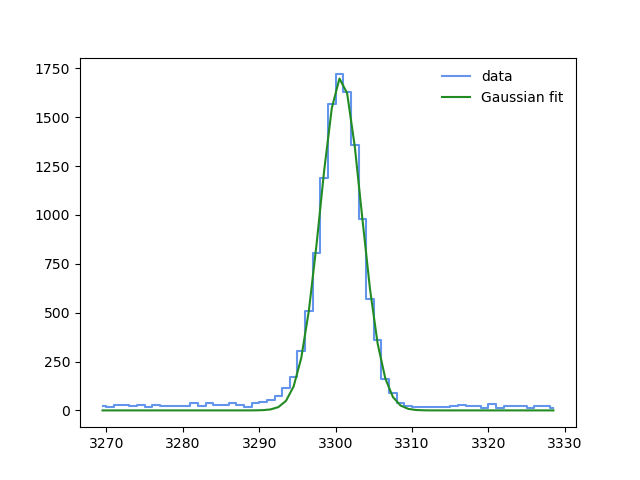

Estimates of (A mu sigma) = ( 1701.438287027319 3300.6739637051596 2.690781632536818 )

Covariance matrix = 
 [[ 2.62193671e+02  5.05274805e-06 -2.76435636e-01]
 [ 5.05274805e-06  8.74353634e-04 -7.99117031e-09]
 [-2.76435636e-01 -7.99117031e-09  8.74353625e-04]] 

Uncertainties in the estimated parameters: 
[ sigma^2(A) sigma^2(mu), sigma^2(sigma) ] = 
[ 262.19367129620366 0.0008743536336408339 0.0008743536253622023 ]

Area of peak is:  11475.842788639093


In [14]:
mu_guess = 3300 # guess of a position of a peak centroid 
n = 30 #number of points on each side to include in fit
# TODO : change n to start+stop as before

gauss = fittingFunctions.perform_Gaussian_fit(data.bin_centers, data.counts, mu_guess, n)

Area = np.sqrt(2*np.pi)*gauss.A*np.abs(gauss.sigma)
print('Area of peak is: ', Area)

### Influence of initial guess on your Gaussian fit - widget <a name="widget_gauss"></a>

# TODO : make all parameters modifyable inside the widget (A,mu,sigma, range) and clearly print uncertainties

Now let's look at how our initial guess of the position of peak centroid and number of points influence out fit. Change numbers for mu_guess and n, and check how the change affects your fit. **TODO : make this the initial demonstration of how fitting works**

In [15]:
mu_guess_widget = widgets.IntSlider(value=3300, min=3200, max=3400, step=1, description=r'mu_guess')
n_widget = widgets.IntSlider(value=30, min=15, max=45, step=1, description=r'n_widget')

interactive_plot=interact.options(manual=True, manual_name="Update")

@interactive_plot(
    mu_guess = mu_guess_widget, n = n_widget)
def interactive_plot(mu_guess = mu_guess_widget.value, n = n_widget.value):
    fittingFunctions.perform_Gaussian_fit(data.bin_centers, data.counts, mu_guess_widget.value, n_widget.value)

interactive(children=(IntSlider(value=3300, description='mu_guess', max=3400, min=3200), IntSlider(value=30, d…

## Improving your fit - accounting for a linear background  <a name="background"></a>

# TODO : change the second peak to have lots more of background and look into fitting it here
- same approach: first widget, then code, then simple function?

Often times we want to subtract the background from our peak as the peak may be on the Compton continuum of other peaks higher in energy. It is needed to be able to correctly determine the intensity of the peak.

**TODO : use same approach here as earlier**

<IPython.core.display.Javascript object>


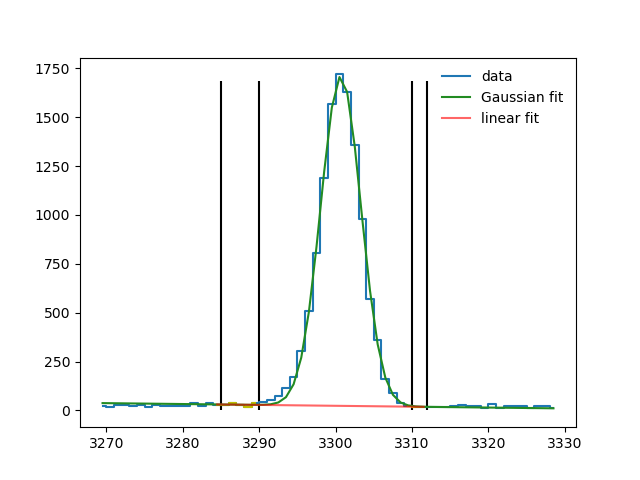

Linear fit estimates (k m) = ( -0.4516607354738622 1514.0357354716984 )

Estimates of (A mu sigma) = ( 1686.1666652864853 3300.6806786415364 2.6354174721402606 )

Covariance matrix = 
 [[ 8.83293440e+01  1.71721456e-06 -9.20375608e-02]
 [ 1.71721456e-06  2.87704369e-04 -2.68428601e-09]
 [-9.20375608e-02 -2.68428601e-09  2.87704366e-04]] 

Uncertainties in the estimated parameters: 
[ sigma^2(A) sigma^2(mu), sigma^2(sigma) ] = 
[ 88.32934398495689 0.00028770436882524883 0.0002877043663450329 ]


In [16]:
#### Your values go here: 

mu_guess = 3300 # guess of a position of a peak centroid
n = 30          #number of points on each side to include in fit

#Let's select channels on both sides of our fit to which we want to fit our line:
left_selection = [3285, 3290]
right_selection = [3310, 3312]##### Now we can perform the fit:

# TODO : rely on results from previous cells here? <-- +1
# TODO : use approach of first fit here as well?
# TODO : alternatively, one can use numpy where:
peak_center_idx = np.where(data.bin_centers>mu_guess)[0][0] # returns idx that fulfill criteria; take first
peak_center_idx = (np.abs(data.bin_centers-mu_guess)).argmin() # find index of the mu guess value in bin_centers array 

# select values from bin_centers and y arrays of your data that correspond to your initiall guess af a peak
peak_x = data.bin_centers[peak_center_idx-n:peak_center_idx+n]
peak_y = data.counts[peak_center_idx-n:peak_center_idx+n]


############ Selecting points to fit linear function
# TODO : this can be solved simpler by using
# select a region with logic statement:
# take values EITHER on the left side 
# (bigger than lower limit AND ('&') smaller than upper limit)
# OR ('|') on the right side
lin_region = ((data.bin_centers>left_selection[0]) & (data.bin_centers<left_selection[1])) | ((data.bin_centers>right_selection[0]) & (data.bin_centers<right_selection[1]))
lin_bc = data.bin_centers[lin_region]
lin_counts = data.counts[lin_region]

left_idx = [(np.abs(data.bin_centers-left_selection[0])).argmin(), (np.abs(data.bin_centers-left_selection[1])).argmin()]
right_idx = [(np.abs(data.bin_centers-right_selection[0])).argmin(), (np.abs(data.bin_centers-right_selection[1])).argmin()]

left_x = data.bin_centers[left_idx[0]:(left_idx[1]+1)]
right_x = data.bin_centers[right_idx[0]:(right_idx[1]+1)]

left_y = data.counts[left_idx[0]:(left_idx[1]+1)]
right_y = data.counts[right_idx[0]:(right_idx[1]+1)]

lin_x = np.concatenate([left_x, right_x])
lin_y = np.concatenate([left_y, right_y])

############ Fitting linear function to selected points

guess = [2, 1]

estimates_lin, covar_matrix = curve_fit(fittingFunctions.LineFunc,
                                    lin_x,
                                    lin_y,
                                    p0 = guess)


############ Subtracting the linear background

peak_lin = fittingFunctions.LineFunc(peak_x, estimates_lin[0], estimates_lin[1]) # 
y_subst = peak_y - peak_lin

############ Fit the Gaussian to the peak without backround

A_guess = data.counts[peak_center_idx]                              # a guess for the amplitude of the peak (you do not need to change it)
sigma_guess = 1                                                # guess for sigma 
guess = [A_guess, mu_guess, sigma_guess]

estimates, covar_matrix = curve_fit(fittingFunctions.GaussFunc,
                                    peak_x,
                                    y_subst,
                                    p0=guess)
A, mu, sigma = estimates[0], estimates[1], estimates[2] # unpack results
# TODO : either above OR below
g_final = fittingFunctions.Gauss(estimates[0], estimates[1], estimates[2], covar_matrix )



############ Plotting results 
# TODO : this is quite a wall of values -- can this be simplified?
plt.figure()
plt.step(peak_x, peak_y, where='mid', label='data')
# #plot points to which linear function is fitted
plt.step(left_x, left_y, where='mid', color='y')
plt.step(right_x, right_y, where='mid', color='y')
# #plot support lines
plt.vlines(left_selection+right_selection, ymin=0, ymax=g_final.A)
# plot Gaussian
#plt.plot(x_fin, GaussFunc(x_fin, g_final.A, g_final.mu, g_final.sigma), color='gray')
plt.plot(peak_x, peak_lin + GaussFunc(peak_x, g_final.A, g_final.mu, g_final.sigma), 'forestgreen', label='Gaussian fit')
# plot linear fit
plt.plot(lin_x, fittingFunctions.LineFunc(lin_x, estimates_lin[0], estimates_lin[1]), color='r', label = 'linear fit', alpha=0.6) 
plt.legend(loc='upper right', frameon=False)
plt.show()

########### Printing results
print("Linear fit estimates (k m) = (", estimates_lin[0], estimates_lin[1], ")\n")
print("Estimates of (A mu sigma) = (", g_final.A, g_final.mu, g_final.sigma, ")\n")
print("Covariance matrix = \n", g_final.covar_matrix, "\n")
print("Uncertainties in the estimated parameters: \n[ sigma^2(A) sigma^2(mu), sigma^2(sigma) ] = \n[", g_final.covar_matrix[0][0], g_final.covar_matrix[1][1], g_final.covar_matrix[2][2], "]" )


### Analysis code  <a name="code_background"></a>

To make a Gaussian fit that takes into account the background just use a function `perform_Gaussian_fit` from `fittingFunctions` package with specifying `left_selection` and `right_selection` arrays. _In case you are interested in how the fit was performed you have a look on the function `perform_Gaussian_fit` [fittingFunctions.py](../fittingFunctions.py)._


**You can just copy the following cell and use it in your Jupyter Notebooks with solutions for laboratories.**

<IPython.core.display.Javascript object>


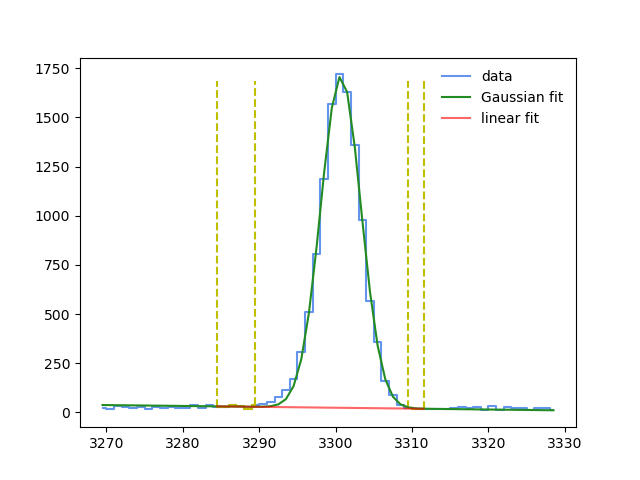

Estimates of (A mu sigma) = ( 1686.1666572422214 3300.68067863157 2.6354174972521753 )

Covariance matrix = 
 [[ 8.83293280e+01  1.71797675e-06 -9.20375679e-02]
 [ 1.71797675e-06  2.87704464e-04 -2.68488877e-09]
 [-9.20375679e-02 -2.68488877e-09  2.87704465e-04]] 

Uncertainties in the estimated parameters: 
[ sigma^2(A) sigma^2(mu), sigma^2(sigma) ] = 
[ 88.32932801661778 0.0002877044638852663 0.0002877044649540639 ]



In [17]:
mu_guess = 3300 # guess of a position of a peak centroid 
n = 30 #number of points on each side to include in fit

#Let's select channels on both sides of our fit to which we want to fit our line: 
left_selection = [3285, 3290]
right_selection = [3310, 3312]

gauss = fittingFunctions.perform_Gaussian_fit(data.bin_centers, data.counts, mu_guess, n, left_selection, right_selection)

### Widget background  <a name="widget_background"></a>

In [18]:
mu_guess_widget = widgets.IntSlider(value=3300, min=3250, max=3350, step=1, description=r'mu_guess')
n_widget = widgets.IntSlider(value=30, min=15, max=45, step=1, description=r'n_widget')
left_selection_widget = widgets.IntRangeSlider(values=[3285, 3290], min=(mu_guess_widget.value - n_widget.value), max=(mu_guess_widget.value - int(n_widget.value/4)))
right_selection_widget = widgets.IntRangeSlider(values=[3310, 3312], min=(mu_guess_widget.value + int(n_widget.value/4)), max=(mu_guess_widget.value + n_widget.value))

def update_left(change):
    left_selection_widget.min = mu_guess_widget.value - n_widget.value
    left_selection_widget.max = mu_guess_widget.value - int(n_widget.value/4)
def update_right(change):    
    right_selection_widget.min = mu_guess_widget.value + int(n_widget.value/4)
    right_selection_widget.max = mu_guess_widget.value + n_widget.value
    
    
left_selection_widget.observe(update_left, 'value')
right_selection_widget.observe(update_right, 'value')

interactive_plot2=interact.options(manual=True, manual_name="Update")

@interactive_plot2(
    mu_guess = mu_guess_widget, n = n_widget, left_selection=left_selection_widget, right_selection=right_selection_widget)

def interactive_plot_background(mu_guess = mu_guess_widget.value, n = n_widget.value, left_selection=left_selection_widget, right_selection=right_selection_widget):
    fittingFunctions.perform_Gaussian_fit(data.bin_centers, data.counts, mu_guess_widget.value, n_widget.value, left_selection_widget.value, right_selection_widget.value)

interactive(children=(IntSlider(value=3300, description='mu_guess', max=3350, min=3250), IntSlider(value=30, d…

## Fit a line - Energy calibration <a name="line"></a>

In spectroscopy experiments it is often essential to calibrate the detector response with respect to a known energies emitted from a so called calibration source. The relationship between the detector response and the energy is mostly assumed linear. The code below exemplifies how to estimate the linear calibration for 'random data'.

# TODO : consider to make this a 'real' energy calibration
- after peak identification, make a linear fit to given energies, then apply calibration to the data and plot spectrum as fcn of energy

In [ ]:
# x and y are some 'random data'
x = np.asarray([1,3,5,7])
y = np.asarray([1.3, 2.1, 2.9, 4.2])

#If you are more or less uncertain about your y-values this can be used in the fit by including the following line.
sigmay = np.asarray([0.5, 0.3, 0.1, 0.2])

# Define the linear function which you want to fit.
def LineFunc(x, k, m):
    return k*x+m

# As for the Gaussian fit the function curve_fit needs a guess for the parameters to be estimated.
guess = [2, 1]

# Perform the fit
estimates, covar_matrix = curve_fit(LineFunc,
                                    x,
                                    y,
                                    p0 = guess,
                                    sigma = sigmay)

print("Estimates of (k m) = (", estimates[0], estimates[1], ")\n")

# plot the result
plt.figure()
plt.plot(x,y, linestyle="", marker="*", label='data points')
plt.plot(x, LineFunc(x, estimates[0], estimates[1]), label='linear fit')
plt.legend(loc='upper left')
plt.show()

# TODO : couple this more directly to what was done before -- maybe even how to use this in the energy calibration step?